Для начала установим все необходимые для работы пакеты


In [2]:
pip install web3==4.2.1

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 481kB 52.9MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 9.7MB 46.5MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.10.1-cp36-cp36m-linux_x86_64.whl size=1256653 sha256=cac09da5a84201cbf1b1152b9c3fe2ef552a7ca65261dd1a4b28d223cdbff06f
  Stored in directory: /root/.cache/pip/wheels/64/2a/18/d962b614e055577e7d9a3e4813e0742f822ca9c8800cc3783a
  Created wheel for lru-dict: filename=lru_dict-1.1.6-cp36-cp36m-linux_x86_64.whl size=25858 sha256=33dfcaca70bf2bfb9d499afefacb6664b365110370282045b83fce9875556e7f
  Stored in directory: /root/.cache/pip/wheels/b7/ef/06/fbdd555907a7d438fb33e4c8675f771ff1cf41917284c51ebf
  Created wheel for parsimonious: filename=parsimonious-0.8.1-cp36-none-any.whl size=42709 sha256=94ee7eb89bbe728c43662a1d573650a033d57bcc673b826d3b574530b886f37b
  Stored in dire

Импортируем необходимые для работы модули

In [0]:
from web3 import Web3
import numpy as np
import matplotlib.pyplot as plt
import math

Переходим к заданию необходимых параметров

In [12]:
STATIC_REWARD = 2   #текущая установленная награда в ETH
TO_ETH = 10**(-18)  #перевод в ETH

col=10              #задаём количество анализируемых блоков
first = 8961400-col*(57-1)
last = 8961400-col*(57-2)
print('Первый из анализируемых блоков:', first)
print('Последний из анализируемых блоков:', last)

absolute_fee = []     
relative_fee = []     
block_number = []
contracts_number =[]
transactions_number = []

Первый из анализируемых блоков: 8960840
Последний из анализируемых блоков: 8960850


Блок функций, которые нам нужны для сбора и анализа данных

In [0]:
#перевод в ETH
def to_eth(weis):
    return weis * TO_ETH


#подсчёт награды за блок и количества обращений к смарт контрактам
def block_fee(block):
    sum_fee = 0
    contracts = 0
    for tr in block.transactions:
        price = tr.gasPrice
        used = web3.eth.getTransactionReceipt(tr.hash).gasUsed
        sum_fee += price * used
        if tr.input != '0x':
            contracts += 1
    return to_eth(sum_fee), contracts


#подсчёт награды за блок
def block_reward(block, fee_value):
    return STATIC_REWARD + fee_value + len(block.uncles)/56

Выполняем подключение к infura

In [0]:
web3 = Web3(Web3.HTTPProvider("https://mainnet.infura.io/v3/6b34738f7d384c74ab9373423e21011e"))

Производим сбор анализируемых данных и вычисляем необходимые статистические параметры

In [15]:
#сбор данных по всем блокам
for block_n in range(first, last+1):
    block = web3.eth.getBlock(block_n, True)
    total_fee, contracts_n = block_fee(block)
    number = block.number
    reward = block_reward(block, total_fee)
    absolute_fee.append(total_fee)
    relative_fee.append(total_fee * 100 / reward)
    block_number.append(number)
    contracts_number.append(contracts_n)
    transactions_number.append(len(block.transactions))

#вычисление статистических параметров
Mx = np.mean(absolute_fee)
median = np.median(absolute_fee)
data_range = np.max(absolute_fee) - np.min(absolute_fee)
Dx = np.var(absolute_fee)
Sx = math.sqrt(Dx)
smart = np.sum(contracts_number)
print('Вычисленные статистические параметры значения комиссии:')
output = {'Математическое ожидание:': Mx,
          'Дисперсия:': Dx,
          'Среднеквадратическое отклонение:': Sx,
          'Разброс:': data_range,
          'Медиана:': median,
          'Кол-во смарт контрактов': smart}
for i, stat in output.items():
    print(i, ': ', round(stat, 2))

Вычисленные статистические параметры значения комиссии:
Математическое ожидание: :  0.13
Дисперсия: :  0.0
Среднеквадратическое отклонение: :  0.07
Разброс: :  0.25
Медиана: :  0.12
Кол-во смарт контрактов :  1482


Переходим к построению статистических графиков

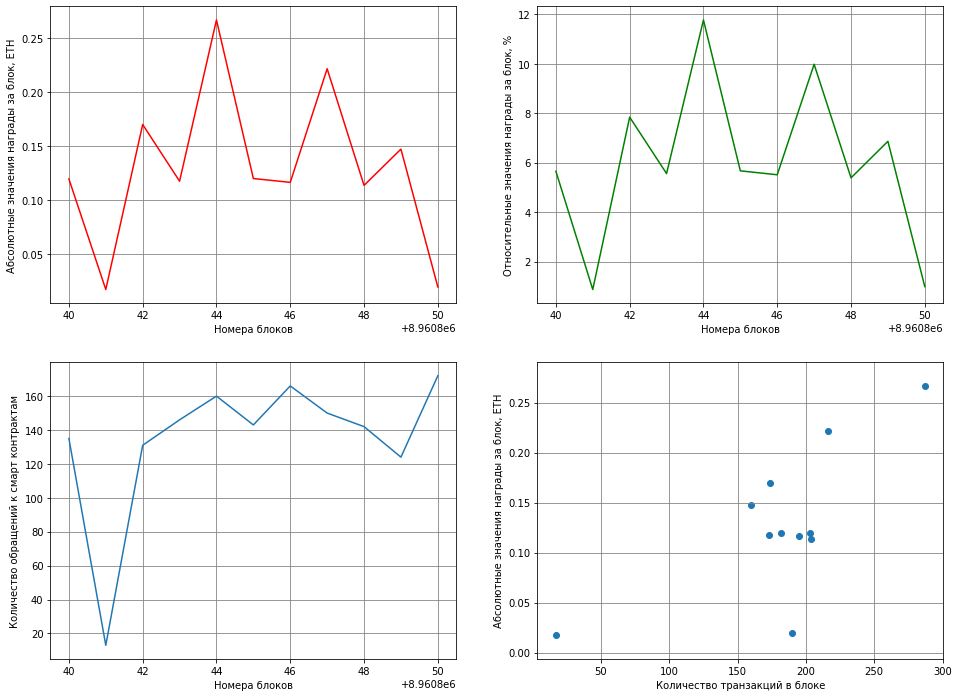

In [17]:
grafic = plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 10})

grafic1 = grafic.add_subplot(221)
grafic1.plot(block_number, absolute_fee, color = 'r')
grafic1.set_xlabel('Номера блоков', )
grafic1.set_ylabel('Абсолютные значения награды за блок, ETH')
plt.grid(color='grey')

grafic2 = grafic.add_subplot(222)
grafic2.plot(block_number, relative_fee, color = 'g')
grafic2.set_xlabel('Номера блоков', )
grafic2.set_ylabel('Относительные значения награды за блок, %')
plt.grid(color='grey')

grafic3 = grafic.add_subplot(223)
grafic3.plot(block_number, contracts_number)
grafic3.set_xlabel('Номера блоков', )
grafic3.set_ylabel('Количество обращений к смарт контрактам')
plt.grid(color='grey')

grafic4 = grafic.add_subplot(224)
grafic4.scatter(transactions_number, absolute_fee)
grafic4.set_xlabel('Количество транзакций в блоке', )
grafic4.set_ylabel('Абсолютные значения награды за блок, ETH')
plt.grid(color='grey')

plt.show()